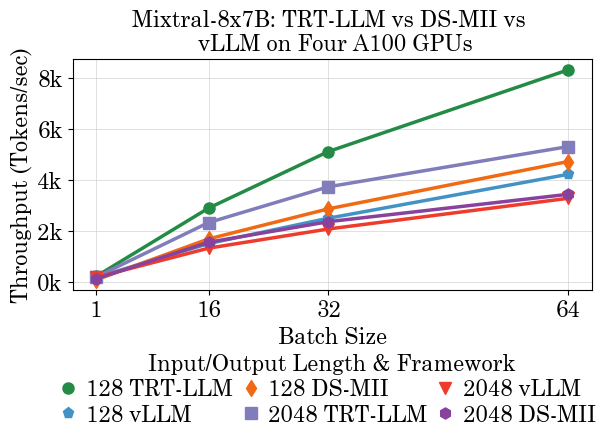

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import csv
from matplotlib import colors
import numpy as np
import matplotlib.pyplot as plt


alias_legend = {
    "meta-llama/Llama-2-7b-hf": "LLaMA-2-7B",
    "meta-llama/Llama-2-70b-hf": "LLaMA-2-70B",
    "meta-llama/Meta-Llama-3-8B": "LLaMA-3-8B",
    "meta-llama/Meta-Llama-3-70B": "LLaMA-3-70B",
    "mistralai/Mistral-7B-v0.1": "Mistral-7B",
    "mistralai/Mistral-7B-v0.3": "Mistral-7B",
    "mistralai/Mixtral-8x7B-v0.1": "Mixtral-8x7B",
    "Qwen/Qwen2-7B": "Qwen2-7B",
    "Qwen/Qwen2-72B": "Qwen2-72B",
    "BAAI/Aquila-7B": "Aquila-7B",
    "Qwen/Qwen1.5-7B": "Qwen1.5-7B",
    "facebook/opt-13b": "OPT-13B",
    "facebook/opt-6.7b": "OPT-6.7B",
    "huggyllama/llama-13b": "LLaMA-13B",
    "huggyllama/llama-7b": "LLaMA-7B",
    "EleutherAI/gpt-j-6b": "GPT-J-6B",
    "meta-llama/Llama-2-13b-hf": "LLaMA-2-13B",
    "google/gemma-1.1-7b-it": "Gemma-1.1-7B",
    "bigscience/bloom-7b1": "Bloom-7.1B",
    "Deci/DeciLM-7B": "DeciLM-7B",
    "google/gemma-7b": "Gemma-7B",
    "Tensor Parallelism": "TP",
    "Pipeline Parallelism": "PP",
    "Expert Parallelism": "EP",
    "Tensor (2) and Expert (2) Parallelism": "TP & PP",
    "Deepspeed": "DS",
    "TensorRT-LLM": "TRT-LLM",
    "vLLM":"vLLM",
    "Deepspeed-MII":"DS-MII",
    "Without": "w/o",
    "With": "w",
    "Nvidia A100 GPU": "A100",
    "Nvidia H100 GPU": "H100",
    "Nvidia GH200 GPU": "GH200",
    "Intel PVC GPU": "PVC",
    "AMD MI250 GPU": "MI250",
    "Habana Gaudi2": "Gaudi2",
    "SambaNova SN40L": "SN40L",
    "Weight = fp16, KV Cache = fp16": "{fp16, fp16}",
    "Weight = fp16, KV Cache = fp8": "{fp16, fp8}",
    "Speculative Decoding": "SD",
    "Weight = full_prec, KV Cache = int8": "{fp16, int8}",
    "Weight = full_prec, KV Cache = fp8": "{fp16, fp8}",
    "Weight = int8_sq, KV Cache = int8": "{int8, int8}",
    "Weight = int8_sq, KV Cache = fp8": "{int8, fp8}"
}


symbol_dict = {"128":{"TensorRT-LLM":"o", "vLLM":"p", "Deepspeed-MII":"d"}, 
               "2048":{"TensorRT-LLM":"s", "vLLM":"v", "Deepspeed-MII":"h"}}

color_dict = {"128":{"TensorRT-LLM":"#238b45", "vLLM":"#4292c6", "Deepspeed-MII":"#f16913"}, 
               "2048":{"TensorRT-LLM":"#807dba", "vLLM":"#ef3b2c", "Deepspeed-MII":"#88419d"}}
            
def read_csv_without_header(csv_file):
    with open(csv_file, "r", newline="") as f:
        reader = csv.reader(f)
        next(reader)

        rows = []
        for row in reader:
            rows.append(row)
    return rows


def get_matching_row(hardware, numhardware, framework, network, inp_out, batch):
    csv_file = "../All_results.csv"
    rows = read_csv_without_header(csv_file)
    
    for row in rows:
        if row != []:
            Hardware = str(row[0]) 
            Num_of_Hardware = int(row[1])
            Framework = str(row[2])
            Model = str(row[3])
            Input_Output_Length = int(row[4]) 
            Batch_Size = int(row[5])
            Latency = float(row[6])
            Throughput = float(row[7])
            
            if Hardware == hardware:
                if Num_of_Hardware == numhardware:
                    if Framework == framework:
                        if Model == network:
                            if Input_Output_Length == inp_out:
                                if Batch_Size == batch:
                                    return Throughput
    return None
    

def get_data_rows():
    
    results_data = []
    legends = []
    symbols = []
    colors  = []
    
    for inp_out in [128, 2048]:
        for framework in ["TensorRT-LLM", "vLLM", "Deepspeed-MII"]:
            for network in ["mistralai/Mixtral-8x7B-v0.1"]:
                for hardware in ["Nvidia A100 GPU"]:
                    batch_row = []
                    for batch in [1, 16, 32, 64]:
                        for numhardware in [4]:
                            throughput = get_matching_row(hardware, numhardware, framework, network, inp_out, batch)
                            batch_row.append(throughput)
                
                if all([x is None for x in batch_row])^ True:
                    results_data.append(batch_row)
                    legends.append(str(inp_out) + " " + alias_legend[framework])      
                    symbols.append(symbol_dict[str(inp_out)][framework])
                    colors.append(color_dict[str(inp_out)][framework])
                            
    x_axis_labels = [1, 16, 32, 64]

    return results_data, x_axis_labels, legends, colors, symbols



def plot_multiple_lines(lines_data, x_axis_labels, legends, colors, symbols, title, xlabel, 
                        ylabel, linewidth, markersize, fontsize, legend_fontsize, n_cols_legend,
                        fig_plot_length, fig_plot_height, legend_title, save_pdf, labelspacing, columnspacing):
    
    plt.figure(figsize=(fig_plot_length, fig_plot_height))
    plt.rcParams['font.family'] = 'Century Schoolbook'
    
    for i, line_data in enumerate(lines_data):
        
        valid_y_axis = [x for x in line_data if x is not None]
        valid_x_axis = x_axis_labels[0:len(valid_y_axis)]
        
        plt.plot(valid_x_axis, valid_y_axis, color=colors[i], marker=symbols[i], 
                 label=str(legends[i]), linewidth = linewidth, markersize = markersize)
    
#     for x_value in x_axis_labels:
#         plt.axvline(x=x_value, color='gray', linestyle='-', alpha=0.5)
    
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    
    plt.title(title, fontsize = fontsize)
    
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    
    plt.xticks(x_axis_labels, fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    
    def thousands_formatter(x, pos):
        return f'{int(x/1000)}k'
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    plt.legend(title=legend_title, loc='lower center', bbox_to_anchor=(0.5, -0.67), 
               ncol=n_cols_legend, fontsize = legend_fontsize, title_fontsize = fontsize, frameon = False, 
               handlelength = 0, labelspacing = labelspacing, columnspacing = columnspacing)
    
    plt.savefig(save_pdf, dpi=300, bbox_inches='tight', pad_inches=0.03)
    plt.show()
    

lines_data, x_axis_labels, legends, colors, symbols = get_data_rows()

plot_title   = "Mixtral-8x7B: TRT-LLM vs DS-MII vs \n vLLM on Four A100 GPUs"
x_axis_title = "Batch Size"
y_axis_title = "Throughput (Tokens/sec)"

linewidth = 2.5
markersize = 8
fontsize = 16
legend_fontsize = 16

n_cols_legend = 3 

fig_plot_length = 6.7
fig_plot_height = 3

labelspacing = 0.2
columnspacing = 0.8


legend_title = "Input/Output Length & Framework"

save_pdf = "TRT_LLM_vLLM_DS_MII.pdf"

plot_multiple_lines(lines_data, x_axis_labels, legends, colors, symbols, 
                    plot_title, x_axis_title, y_axis_title, 
                    linewidth, markersize, fontsize, legend_fontsize, n_cols_legend, 
                    fig_plot_length, fig_plot_height, legend_title, save_pdf, labelspacing, columnspacing)